# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

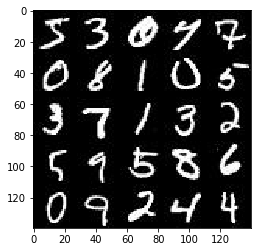

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

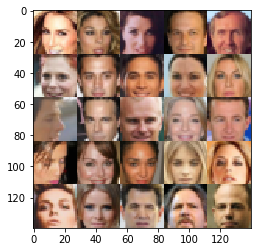

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [96]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    # Placeholder for input images
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    
    # Placeholder for noise vector
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    # Placeholder for leanring rate
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [221]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        dropout=0.1
        use_dropout = True
        
        # Input layer (input is 28x28x3) (note: does not use batch normalization or dropout)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)     
        # output is 14x14x64
        
        # Convolution layer 1 (output is 7x7x128)
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        
        if use_dropout:
            dropout2 = tf.layers.dropout(bn2, rate=dropout)
            relu2 = tf.maximum(alpha * dropout2, dropout2) 
        else:
            relu2 = tf.maximum(alpha * bn2, bn2)
                
        # Convolution layer 2 (output is 4x4x256)
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        
        if use_dropout:
            dropout3 = tf.layers.dropout(bn3, rate=dropout)
            relu3 = tf.maximum(alpha * dropout3, dropout3)  
        else:
            relu3 = tf.maximum(alpha * bn3, bn3) 

        # Output layer (output is 1)
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [222]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha=0.2
        dropout=0.25
        use_dropout = False
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack (output is 2x2x512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)    
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        # Convolution transpose layer 1 (output is 7x7x256)
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)    
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # Convolution transpose layer 2 (output is 14x14x128)
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)      
        relu3 = tf.maximum(alpha * bn3, bn3)
            
        # Additional convolution transpose layer 3 with stride 1 (output is 14x14x128)
        x4 = tf.layers.conv2d_transpose(relu3, 128, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        
        if use_dropout:
            dropout4 = tf.layers.dropout(bn4, rate=dropout)
            relu4 = tf.maximum(alpha * dropout4, dropout4)
        else:
            relu4 = tf.maximum(alpha * bn4, bn4)
                                        
        # Output layer (output is 28x28xout_channel_dim)
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=2, padding='same')
               
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [223]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
        
    # To help discriminator generalize better labels for real images are reduced from 1.0 to 0.9
    smooth = 0.1
    d_labels_real = tf.ones_like(d_logits_real) * (1 - smooth)
        
    # lables are all zero for fake images
    d_labels_fake = tf.zeros_like(d_model_fake)   
            
    # Get loss for discriminator
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_fake))
    
    # Get total discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    # Get loss for generator
    
    # labels are all ones as generator is trying to fool discriminator
    g_labels_fake = tf.ones_like(d_model_fake)    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels_fake))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [224]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    

    # Optimize (use AdamOptimizer for both)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        # refer https://github.com/soumith/ganhacks
        # d_train_opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [225]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [232]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Image params
    _, image_width, image_height, image_channels = data_shape  
    print("image_width={}, image_height={}, image_channels={}".format(image_width, image_height, image_channels))
    
    # Get the placeholders
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Get the loss
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    
    # Get the optimization operations
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    output_stats_step_freq = 64
    output_image_step_freq = 256
    show_n_images = 25
    
    # Dictionary used to track discriminator and generator losses
    history = {}
    history["discriminator"] = []
    history["generator"] = []
    history["iteration"] = []
        
    discriminator_train_loss = 0
    generator_train_loss = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # Scale images to range of -1 to 1 to match generator range
                batch_images *= 2.0
                               
                # Sample random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers   
                if generator_train_loss <= discriminator_train_loss:
                    # just optimise both generator and discriminator
                    _ = sess.run(d_train_opt, 
                                     feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr : learning_rate})
                    
                    _ = sess.run(g_train_opt, 
                                     feed_dict={inputs_z: batch_z, inputs_real: batch_images, lr : learning_rate})
                else:
                    # just optimise the generator
                    _ = sess.run(g_train_opt, 
                                     feed_dict={inputs_z: batch_z, inputs_real: batch_images, lr : learning_rate})
                    
                if steps % output_stats_step_freq == 0:
                    # Get the discriminator and generator losses
                    discriminator_train_loss = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    
                    generator_train_loss = g_loss.eval({inputs_z: batch_z})
                   
                    print("Epoch {}/{}: Discriminator Loss: {:.4f}, Generator Loss: {:.4f}".format(
                        epoch_i + 1, 
                        epoch_count, 
                        discriminator_train_loss, 
                        generator_train_loss))
                          
                    # Track discriminator and generator losses 
                    history["discriminator"].append(discriminator_train_loss)
                    history["generator"].append(generator_train_loss)
                    history["iteration"].append(steps)
                    
                if steps % output_image_step_freq == 0:
                    show_generator_output(sess, show_n_images, inputs_z, image_channels, data_image_mode)
                    
    return history

In [233]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the loss for the discriminator and generator
    :history: Dictionary of discriminator and generator losses
    """
    event_count = range(1, len(history["discriminator"]) + 1)

    # visualize loss history
    plt.plot(history["iteration"], history["discriminator"], 'r-')
    plt.plot(history["iteration"], history["generator"], 'b-')
    plt.legend(['Discriminator Loss', 'Generator Loss'])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

image_width=28, image_height=28, image_channels=1
Epoch 1/2: Discriminator Loss: 1.2994, Generator Loss: 0.5903
Epoch 1/2: Discriminator Loss: 1.2875, Generator Loss: 1.0701
Epoch 1/2: Discriminator Loss: 1.2885, Generator Loss: 0.6769
Epoch 1/2: Discriminator Loss: 1.2970, Generator Loss: 1.6228


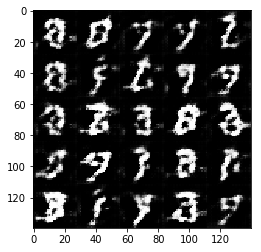

Epoch 1/2: Discriminator Loss: 6.2391, Generator Loss: 0.0074
Epoch 1/2: Discriminator Loss: 1.0627, Generator Loss: 1.2637
Epoch 1/2: Discriminator Loss: 5.5224, Generator Loss: 0.0141
Epoch 1/2: Discriminator Loss: 1.4158, Generator Loss: 0.5822


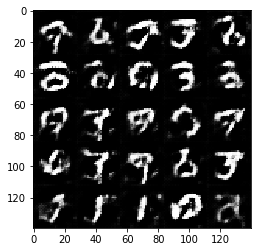

Epoch 1/2: Discriminator Loss: 1.2496, Generator Loss: 1.5098
Epoch 1/2: Discriminator Loss: 6.0413, Generator Loss: 0.0113
Epoch 1/2: Discriminator Loss: 1.1592, Generator Loss: 0.9378
Epoch 1/2: Discriminator Loss: 1.2378, Generator Loss: 0.8765


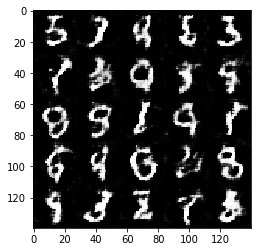

Epoch 1/2: Discriminator Loss: 1.4826, Generator Loss: 0.4818
Epoch 1/2: Discriminator Loss: 1.4891, Generator Loss: 0.5610
Epoch 1/2: Discriminator Loss: 1.2107, Generator Loss: 0.7921
Epoch 1/2: Discriminator Loss: 1.4562, Generator Loss: 0.9713


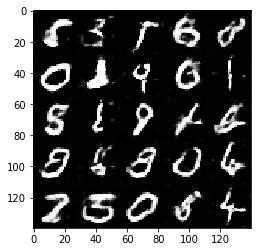

Epoch 1/2: Discriminator Loss: 1.2441, Generator Loss: 0.6278
Epoch 1/2: Discriminator Loss: 1.2310, Generator Loss: 1.1164
Epoch 1/2: Discriminator Loss: 1.6606, Generator Loss: 0.3710
Epoch 1/2: Discriminator Loss: 1.3000, Generator Loss: 0.6857


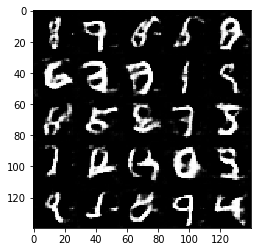

Epoch 1/2: Discriminator Loss: 1.4844, Generator Loss: 0.4433
Epoch 1/2: Discriminator Loss: 1.5350, Generator Loss: 0.5695
Epoch 1/2: Discriminator Loss: 1.1876, Generator Loss: 0.6939
Epoch 1/2: Discriminator Loss: 1.2828, Generator Loss: 1.0589


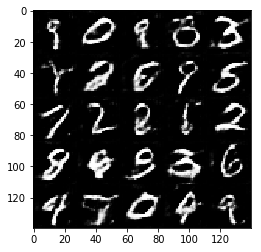

Epoch 1/2: Discriminator Loss: 1.1071, Generator Loss: 0.7979
Epoch 1/2: Discriminator Loss: 1.2032, Generator Loss: 0.7093
Epoch 1/2: Discriminator Loss: 1.0250, Generator Loss: 1.1307
Epoch 1/2: Discriminator Loss: 4.6798, Generator Loss: 0.0307


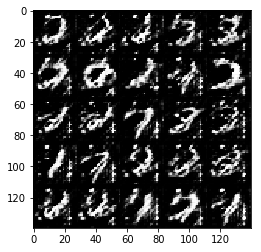

Epoch 1/2: Discriminator Loss: 1.9465, Generator Loss: 0.2688
Epoch 2/2: Discriminator Loss: 1.1523, Generator Loss: 0.9143
Epoch 2/2: Discriminator Loss: 1.3621, Generator Loss: 0.5087
Epoch 2/2: Discriminator Loss: 1.0867, Generator Loss: 1.0700


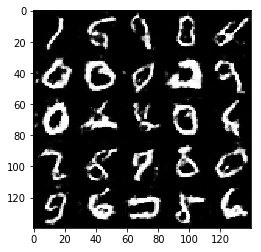

Epoch 2/2: Discriminator Loss: 1.0173, Generator Loss: 0.9241
Epoch 2/2: Discriminator Loss: 1.2056, Generator Loss: 1.2467
Epoch 2/2: Discriminator Loss: 4.2560, Generator Loss: 0.0424
Epoch 2/2: Discriminator Loss: 0.9922, Generator Loss: 1.1985


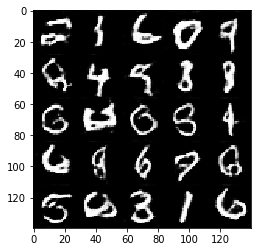

Epoch 2/2: Discriminator Loss: 3.7275, Generator Loss: 0.0642
Epoch 2/2: Discriminator Loss: 1.2045, Generator Loss: 1.2901
Epoch 2/2: Discriminator Loss: 3.9691, Generator Loss: 0.0497
Epoch 2/2: Discriminator Loss: 1.1290, Generator Loss: 1.9770


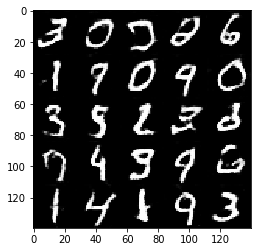

Epoch 2/2: Discriminator Loss: 4.0560, Generator Loss: 0.0612
Epoch 2/2: Discriminator Loss: 1.1306, Generator Loss: 1.7278
Epoch 2/2: Discriminator Loss: 5.5351, Generator Loss: 0.0177
Epoch 2/2: Discriminator Loss: 1.4121, Generator Loss: 0.6981


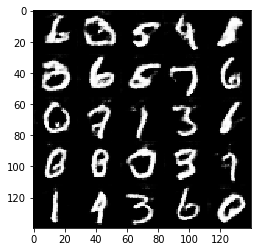

Epoch 2/2: Discriminator Loss: 1.1765, Generator Loss: 0.6635
Epoch 2/2: Discriminator Loss: 1.1098, Generator Loss: 0.7375
Epoch 2/2: Discriminator Loss: 1.1917, Generator Loss: 1.8109
Epoch 2/2: Discriminator Loss: 4.2102, Generator Loss: 0.0547


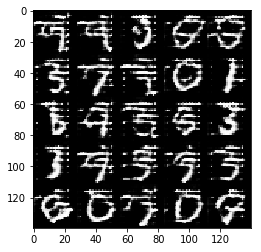

Epoch 2/2: Discriminator Loss: 1.2954, Generator Loss: 0.5950
Epoch 2/2: Discriminator Loss: 1.0008, Generator Loss: 1.0285
Epoch 2/2: Discriminator Loss: 3.7091, Generator Loss: 0.0663
Epoch 2/2: Discriminator Loss: 0.8526, Generator Loss: 1.2227


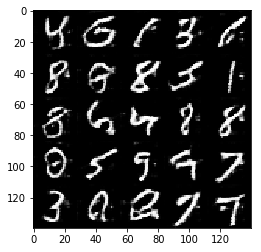

Epoch 2/2: Discriminator Loss: 3.4398, Generator Loss: 0.0721
Epoch 2/2: Discriminator Loss: 1.0834, Generator Loss: 1.2205
Epoch 2/2: Discriminator Loss: 2.6664, Generator Loss: 0.1613
Epoch 2/2: Discriminator Loss: 0.8376, Generator Loss: 1.1717


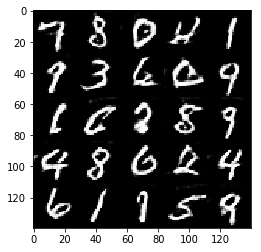

Epoch 2/2: Discriminator Loss: 3.8113, Generator Loss: 0.0597
Epoch 2/2: Discriminator Loss: 1.0372, Generator Loss: 0.9272


In [234]:
# R2: 32 --> 16
batch_size = 32

z_dim = 100

learning_rate = 0.001

# R2: 0.5 --> 0.25
beta1 = 0.3 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    training_loss = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

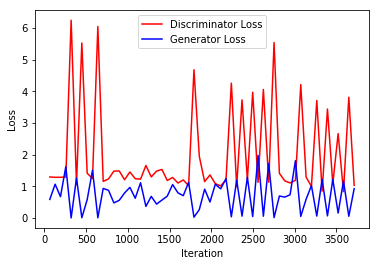

In [235]:
plot_loss(training_loss)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

image_width=28, image_height=28, image_channels=3
Epoch 1/1: Discriminator Loss: 1.2084, Generator Loss: 0.9699
Epoch 1/1: Discriminator Loss: 1.6778, Generator Loss: 2.5812
Epoch 1/1: Discriminator Loss: 8.6039, Generator Loss: 0.0023
Epoch 1/1: Discriminator Loss: 1.7878, Generator Loss: 0.5559


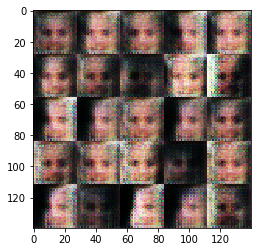

Epoch 1/1: Discriminator Loss: 1.4629, Generator Loss: 1.6163
Epoch 1/1: Discriminator Loss: 6.8410, Generator Loss: 0.0046
Epoch 1/1: Discriminator Loss: 1.3765, Generator Loss: 0.6807
Epoch 1/1: Discriminator Loss: 1.4609, Generator Loss: 0.7077


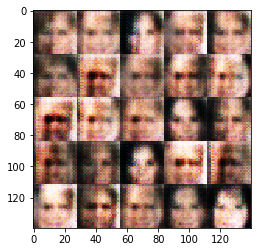

Epoch 1/1: Discriminator Loss: 1.3075, Generator Loss: 0.7359
Epoch 1/1: Discriminator Loss: 1.3049, Generator Loss: 0.7557
Epoch 1/1: Discriminator Loss: 1.3028, Generator Loss: 1.0307
Epoch 1/1: Discriminator Loss: 1.0495, Generator Loss: 1.0324


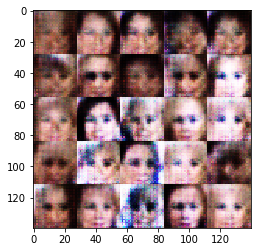

Epoch 1/1: Discriminator Loss: 0.9728, Generator Loss: 0.9051
Epoch 1/1: Discriminator Loss: 1.4683, Generator Loss: 0.4490
Epoch 1/1: Discriminator Loss: 1.3305, Generator Loss: 0.8746
Epoch 1/1: Discriminator Loss: 1.4560, Generator Loss: 0.5911


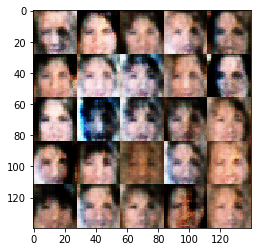

Epoch 1/1: Discriminator Loss: 1.3930, Generator Loss: 0.5181
Epoch 1/1: Discriminator Loss: 0.5559, Generator Loss: 2.2538
Epoch 1/1: Discriminator Loss: 5.1265, Generator Loss: 0.0107
Epoch 1/1: Discriminator Loss: 1.2927, Generator Loss: 0.7547


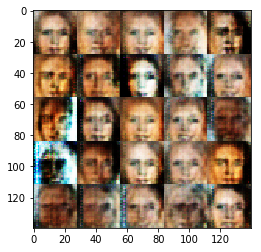

Epoch 1/1: Discriminator Loss: 1.4388, Generator Loss: 0.4472
Epoch 1/1: Discriminator Loss: 1.2057, Generator Loss: 0.8618
Epoch 1/1: Discriminator Loss: 1.1309, Generator Loss: 0.8295
Epoch 1/1: Discriminator Loss: 1.3279, Generator Loss: 0.8504


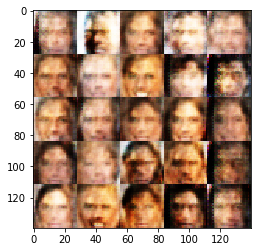

Epoch 1/1: Discriminator Loss: 1.2913, Generator Loss: 0.7435
Epoch 1/1: Discriminator Loss: 1.2874, Generator Loss: 0.8926
Epoch 1/1: Discriminator Loss: 1.4107, Generator Loss: 0.6927
Epoch 1/1: Discriminator Loss: 1.1626, Generator Loss: 0.9244


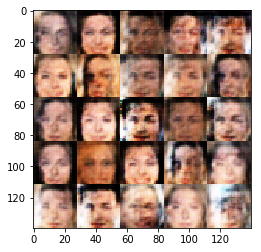

Epoch 1/1: Discriminator Loss: 1.1289, Generator Loss: 0.9192
Epoch 1/1: Discriminator Loss: 1.2967, Generator Loss: 0.7729
Epoch 1/1: Discriminator Loss: 1.2361, Generator Loss: 1.4949
Epoch 1/1: Discriminator Loss: 6.2588, Generator Loss: 0.0057


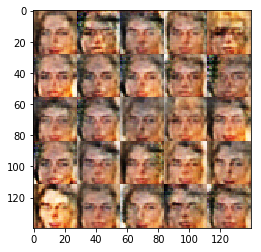

Epoch 1/1: Discriminator Loss: 1.1717, Generator Loss: 0.8622
Epoch 1/1: Discriminator Loss: 1.1452, Generator Loss: 1.0065
Epoch 1/1: Discriminator Loss: 1.5449, Generator Loss: 0.4301
Epoch 1/1: Discriminator Loss: 1.2290, Generator Loss: 0.7771


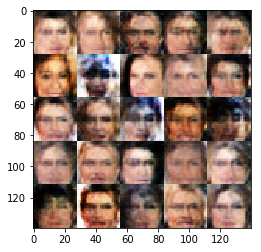

Epoch 1/1: Discriminator Loss: 1.8039, Generator Loss: 0.3356
Epoch 1/1: Discriminator Loss: 1.3476, Generator Loss: 0.6304
Epoch 1/1: Discriminator Loss: 1.4811, Generator Loss: 0.5415
Epoch 1/1: Discriminator Loss: 1.0689, Generator Loss: 1.4278


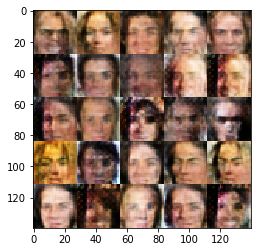

Epoch 1/1: Discriminator Loss: 5.7859, Generator Loss: 0.0076
Epoch 1/1: Discriminator Loss: 1.4120, Generator Loss: 0.7056
Epoch 1/1: Discriminator Loss: 1.2498, Generator Loss: 0.7294
Epoch 1/1: Discriminator Loss: 1.1775, Generator Loss: 0.7274


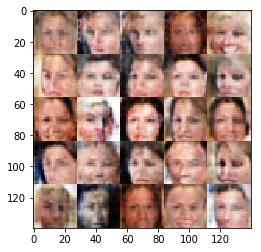

Epoch 1/1: Discriminator Loss: 1.2860, Generator Loss: 0.8847
Epoch 1/1: Discriminator Loss: 1.2901, Generator Loss: 0.8732
Epoch 1/1: Discriminator Loss: 1.3256, Generator Loss: 0.6055
Epoch 1/1: Discriminator Loss: 1.0051, Generator Loss: 1.1237


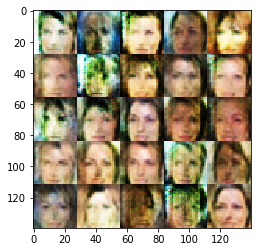

Epoch 1/1: Discriminator Loss: 5.2781, Generator Loss: 0.0134
Epoch 1/1: Discriminator Loss: 1.7155, Generator Loss: 0.3531
Epoch 1/1: Discriminator Loss: 1.2924, Generator Loss: 0.6217
Epoch 1/1: Discriminator Loss: 1.0273, Generator Loss: 1.0694


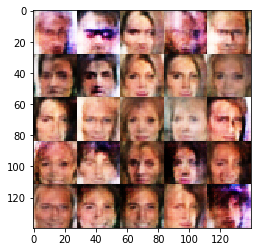

Epoch 1/1: Discriminator Loss: 5.1949, Generator Loss: 0.0122
Epoch 1/1: Discriminator Loss: 1.6184, Generator Loss: 0.3742
Epoch 1/1: Discriminator Loss: 1.0113, Generator Loss: 1.3489
Epoch 1/1: Discriminator Loss: 4.7356, Generator Loss: 0.0222


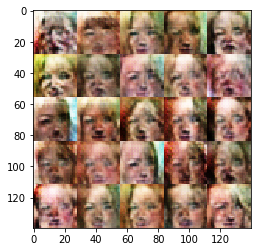

Epoch 1/1: Discriminator Loss: 1.0302, Generator Loss: 2.1581
Epoch 1/1: Discriminator Loss: 5.2717, Generator Loss: 0.0158
Epoch 1/1: Discriminator Loss: 1.4040, Generator Loss: 0.5839
Epoch 1/1: Discriminator Loss: 1.3788, Generator Loss: 0.8096


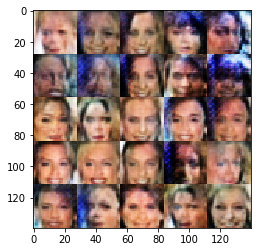

Epoch 1/1: Discriminator Loss: 1.2546, Generator Loss: 1.0979
Epoch 1/1: Discriminator Loss: 1.1208, Generator Loss: 0.7486
Epoch 1/1: Discriminator Loss: 1.2260, Generator Loss: 0.8038
Epoch 1/1: Discriminator Loss: 1.1821, Generator Loss: 0.8871


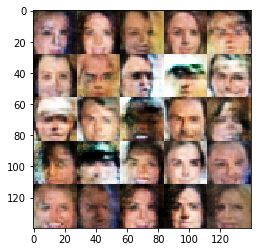

Epoch 1/1: Discriminator Loss: 1.6728, Generator Loss: 0.3840
Epoch 1/1: Discriminator Loss: 1.2445, Generator Loss: 0.9221
Epoch 1/1: Discriminator Loss: 1.2524, Generator Loss: 1.0945
Epoch 1/1: Discriminator Loss: 1.3247, Generator Loss: 1.7120


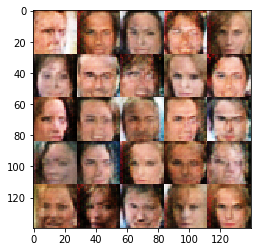

Epoch 1/1: Discriminator Loss: 5.5370, Generator Loss: 0.0157
Epoch 1/1: Discriminator Loss: 1.3156, Generator Loss: 1.0109
Epoch 1/1: Discriminator Loss: 1.1306, Generator Loss: 1.0150
Epoch 1/1: Discriminator Loss: 0.9473, Generator Loss: 2.4163


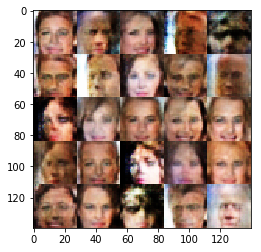

Epoch 1/1: Discriminator Loss: 5.2419, Generator Loss: 0.0226
Epoch 1/1: Discriminator Loss: 1.4405, Generator Loss: 0.8954
Epoch 1/1: Discriminator Loss: 0.8959, Generator Loss: 1.5405
Epoch 1/1: Discriminator Loss: 4.7174, Generator Loss: 0.0223


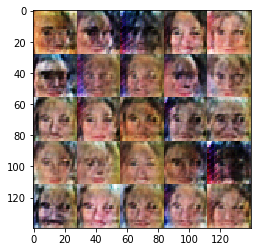

Epoch 1/1: Discriminator Loss: 1.0370, Generator Loss: 1.5000
Epoch 1/1: Discriminator Loss: 5.0196, Generator Loss: 0.0186
Epoch 1/1: Discriminator Loss: 1.3672, Generator Loss: 0.8714
Epoch 1/1: Discriminator Loss: 1.4232, Generator Loss: 0.4769


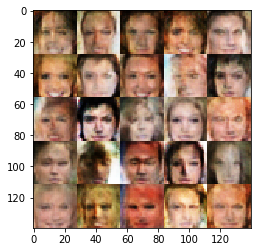

Epoch 1/1: Discriminator Loss: 1.4508, Generator Loss: 0.4902
Epoch 1/1: Discriminator Loss: 1.2801, Generator Loss: 0.7843
Epoch 1/1: Discriminator Loss: 1.2304, Generator Loss: 0.8959
Epoch 1/1: Discriminator Loss: 1.3049, Generator Loss: 0.8346


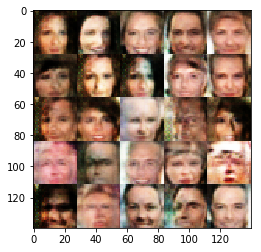

Epoch 1/1: Discriminator Loss: 1.3479, Generator Loss: 1.0333
Epoch 1/1: Discriminator Loss: 1.3201, Generator Loss: 0.8829
Epoch 1/1: Discriminator Loss: 1.2398, Generator Loss: 0.7466
Epoch 1/1: Discriminator Loss: 1.3257, Generator Loss: 0.6545


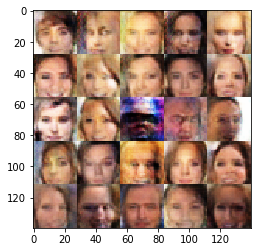

Epoch 1/1: Discriminator Loss: 1.1706, Generator Loss: 0.9736
Epoch 1/1: Discriminator Loss: 1.2262, Generator Loss: 0.7277
Epoch 1/1: Discriminator Loss: 1.4630, Generator Loss: 0.4976
Epoch 1/1: Discriminator Loss: 1.2515, Generator Loss: 0.6374


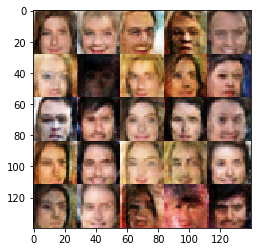

Epoch 1/1: Discriminator Loss: 1.3824, Generator Loss: 0.6270
Epoch 1/1: Discriminator Loss: 1.1254, Generator Loss: 0.7337
Epoch 1/1: Discriminator Loss: 1.4831, Generator Loss: 0.7983
Epoch 1/1: Discriminator Loss: 1.3404, Generator Loss: 1.3250


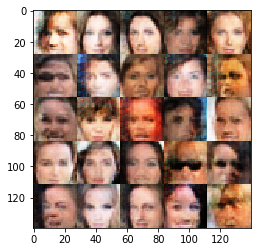

Epoch 1/1: Discriminator Loss: 1.3087, Generator Loss: 0.7168
Epoch 1/1: Discriminator Loss: 1.5205, Generator Loss: 0.4120


In [236]:
# R2: 64 --> 32
batch_size = 32

z_dim = 100

# R2: 0.0005 --> 0.001
learning_rate = 0.0005

# R2: 0.5 --> 0.2
beta1 = 0.3 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    training_loss = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

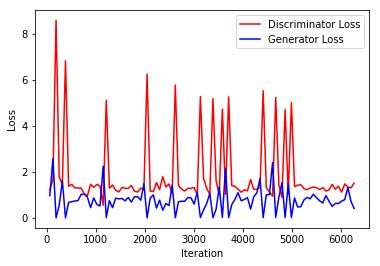

In [237]:
plot_loss(training_loss)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.